In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive/')

path = "/content/drive/My Drive/segmentation/"

Mounted at /content/drive/


In [2]:
X_train = np.load(path + 'X_train.npy').reshape(-1, 1, 128, 128)
y_train = np.load(path + 'y_train.npy').reshape(-1, 1, 128, 128)
X_val = np.load(path + 'X_val.npy').reshape(-1, 1, 128, 128)
y_val = np.load(path + 'y_val.npy').reshape(-1, 1, 128, 128)
X_test = np.load(path + 'X_test.npy').reshape(-1, 1, 128, 128)
y_test = np.load(path + 'y_test.npy').reshape(-1, 1, 128, 128)

In [3]:
class FromNumpyDataset(Dataset):  # Inherit from Dataset class
    def __init__(self, data, target):
        ## Add code here
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)

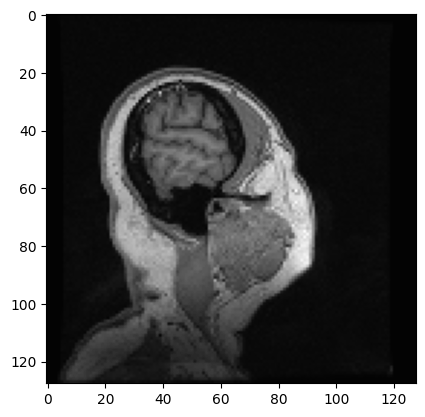

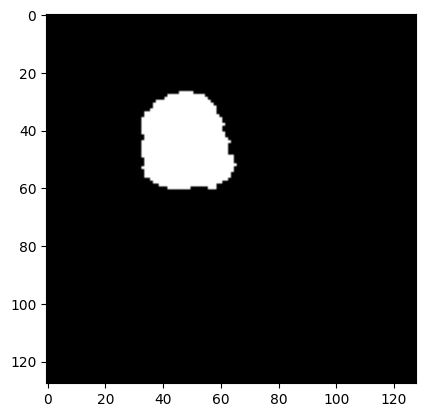

In [4]:
plt.imshow(X_train[0].squeeze(0), cmap='gray')
plt.show()
plt.imshow(y_train[0].squeeze(0), cmap='gray')
plt.show()

In [5]:
def to_one_hot(y, num_classes):
    y = y.squeeze()

    y_onehot = np.zeros((y.shape[0], num_classes, y.shape[1], y.shape[2]))

    for i in range(num_classes):
        y_onehot[:, i, :, :] = (y == i)

    return y_onehot

y_train = to_one_hot(y_train, 2)
y_val = to_one_hot(y_val, 2)
y_test = to_one_hot(y_test, 2)

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, init_features=4, out_channels=2):
        super(UNet, self).__init__()

        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(128, 32, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
        ])
        self.final_conv1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.final_conv2 = nn.Conv2d(16, out_channels, kernel_size=3, padding=1)
        self.act = nn.LeakyReLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        skips = []
        for i, layer in enumerate(self.down_layers):
            x = self.act(layer(x))
            if i < 2:
                skips.append(x)
                x = self.downscale(x)

        for i, layer in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x = torch.concatenate( [x, skips.pop()], axis=1)
            x = self.act(layer(x))

        x = self.act(self.final_conv1(x))
        x = self.final_conv2(x)
        return x

In [7]:
def train(model, dataloader, optim, loss_fn, epoch, device):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(dataloader):
        data = torch.tensor(data, requires_grad=True).to(device)
        target = torch.tensor(target, requires_grad=True).to(device)

        output = model(data)
        loss = loss_fn(output, target)
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                    epoch, (batch_idx+1) * len(data), len(dataloader.dataset),
                    100. * (batch_idx+1) / len(dataloader), loss.item()
            ))

    mean_loss = total_loss / len(dataloader)
    mean_loss = mean_loss.detach().cpu().numpy()
    print('Training mean loss: {:.4f}'.format(mean_loss))

    return mean_loss

In [8]:
def test(model, test_dataloader, optim, loss_fn, epoch, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_dataloader):
            data = torch.tensor(data, requires_grad=True).to(device)
            target = torch.tensor(target, requires_grad=True).to(device)

            output = model(data)
            loss = loss_fn(output, target)

            total_loss += loss

        mean_loss = total_loss / len(test_dataloader)

    mean_loss = mean_loss.detach().cpu().numpy()
    print('Test mean loss: {:.4f}\n'.format(mean_loss))
    return mean_loss

In [9]:
config = {
    'batch_size': 32,
    'num_epoch': 20,
    'lr': 1e-3
}

In [10]:
train_dataset = FromNumpyDataset(X_train, y_train)
test_dataset = FromNumpyDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet(in_channels=1, init_features=4, out_channels=2).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=config['lr'])

losses = []
for epoch in range(config['num_epoch']):
    train_loss = train(model, train_dataloader, optim, loss_fn, epoch, device)
    test_loss = test(model, test_dataloader, optim, loss_fn, epoch, device)

<ipython-input-7-fb73aacebc69>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, requires_grad=True).to(device)
<ipython-input-7-fb73aacebc69>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, requires_grad=True).to(device)


Train Epoch: 0 [32/4000 (1%)]	Loss: 11.219861

Train Epoch: 0 [1632/4000 (41%)]	Loss: 0.300193

Train Epoch: 0 [3232/4000 (81%)]	Loss: 0.064724

Training mean loss: 0.6391


<ipython-input-8-7f2beac94988>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, requires_grad=True).to(device)


Test mean loss: 0.0445

Train Epoch: 1 [32/4000 (1%)]	Loss: 0.043669

Train Epoch: 1 [1632/4000 (41%)]	Loss: 0.033269

Train Epoch: 1 [3232/4000 (81%)]	Loss: 0.027790

Training mean loss: 0.0323
Test mean loss: 0.0262

Train Epoch: 2 [32/4000 (1%)]	Loss: 0.022572

Train Epoch: 2 [1632/4000 (41%)]	Loss: 0.020393

Train Epoch: 2 [3232/4000 (81%)]	Loss: 0.020477

Training mean loss: 0.0224
Test mean loss: 0.0234

Train Epoch: 3 [32/4000 (1%)]	Loss: 0.020444

Train Epoch: 3 [1632/4000 (41%)]	Loss: 0.019764

Train Epoch: 3 [3232/4000 (81%)]	Loss: 0.019854

Training mean loss: 0.0191
Test mean loss: 0.0189

Train Epoch: 4 [32/4000 (1%)]	Loss: 0.015849

Train Epoch: 4 [1632/4000 (41%)]	Loss: 0.017910

Train Epoch: 4 [3232/4000 (81%)]	Loss: 0.016416

Training mean loss: 0.0178
Test mean loss: 0.0177

Train Epoch: 5 [32/4000 (1%)]	Loss: 0.017232

Train Epoch: 5 [1632/4000 (41%)]	Loss: 0.014894

Train Epoch: 5 [3232/4000 (81%)]	Loss: 0.015087

Training mean loss: 0.0160
Test mean loss: 0.0167

T

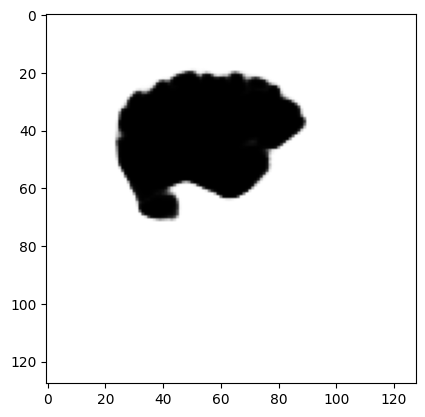

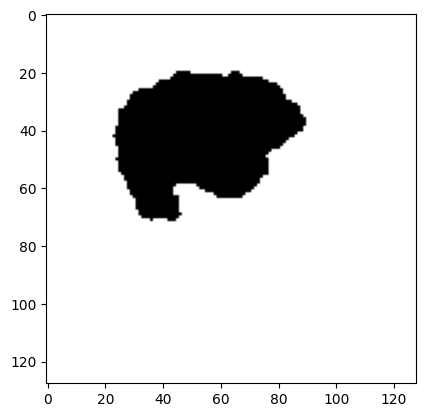

In [29]:
model.eval()
with torch.no_grad():
    test_image = torch.from_numpy(X_test[100]).float().to(device)
    segmentation = nn.Sigmoid()(model(test_image.unsqueeze(0)))
    segmentation = segmentation.detach().cpu().numpy()
    plt.imshow(segmentation[0][0], cmap='gray')
    plt.show()
    plt.imshow(y_test[100][0], cmap='gray')
    plt.show()